# Analyze conformational entropy, as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computational entropy, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
print(len(df.index))
# 115599 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

115599


In [3]:
# what do we have
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'Volume',
       'NumRotorsStrict', 'NumRotors', 'NumMethyl', 'NumAmine', 'NumHydroxyl',
       'HDonors', 'HAcceptors', 'RingCount', 'NumAromaticRings',
       'MaxAbsPartialChg', 'MinAbsPartialChg', 'MaxPartialChg',
       'MinPartialChg', 'TPSA', 'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'HallKierAlpha', 'BertzCT', 'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2',
       'Kappa3', 'FractionCSP3', 'NumBridgeheadAtoms', 'NumSpiroAtoms',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6', 'ECFP4',
       'ECFP6'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,Volume,NumRotorsStrict,NumRotors,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,...,115599.000000,115599.000000,115599.000000,1.155990e+05,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000
mean,34.600737,396.587555,149.397586,182.867627,28.846954,31.686105,403.960759,312.795836,4.585844,5.305349,...,0.939662,0.000980,4.216079,1.815609e-01,6.963633,18.400851,35.212779,56.374510,80.246923,104.314319
std,12.579259,144.674773,8.564845,4.143806,9.175250,10.688507,124.997746,94.665169,2.663472,3.052690,...,0.066122,0.002114,0.976017,1.498155e-01,11.066574,32.883641,64.505961,103.662286,146.573767,188.945147
min,0.004000,24.589368,95.997696,158.891584,4.000000,3.000000,56.026215,50.192000,0.000000,0.000000,...,0.098074,0.000012,1.231888,3.065851e-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,26.387000,288.953316,144.527912,180.334584,22.000000,24.000000,313.073537,243.912000,3.000000,3.000000,...,0.912651,0.000315,3.533319,7.594415e-02,2.000000,3.000000,4.000000,6.000000,7.000000,8.000000
50%,36.106000,405.266424,151.004744,183.861696,30.000000,33.000000,416.107578,322.304000,4.000000,5.000000,...,0.961570,0.000554,4.156412,1.438170e-01,4.000000,8.000000,14.000000,20.000000,27.000000,33.000000
75%,43.851000,483.881692,154.966992,185.543664,34.000000,38.000000,476.114814,368.372000,6.000000,7.000000,...,0.987186,0.001016,4.830287,2.476433e-01,8.000000,20.000000,39.000000,62.000000,89.000000,117.000000
max,69.453000,1689.051512,188.941072,203.702224,128.000000,168.000000,2039.240573,1132.392000,20.000000,20.000000,...,0.999999,0.235738,12.050900,9.944582e-01,427.000000,981.000000,1469.000000,2244.000000,2997.000000,4137.000000


The goal is to understand how the computed conformational entropies change with molecular structure (e.g., number of rotatable bonds).

First off, let's try the formula from "Large-scale calculations of gas phase thermochemistry: Enthalpy of formation, standard entropy, and heat capacity"
*J. Chem. Phys.* 145 art. 114305 (2016); https://doi.org/10.1063/1.4962627

$$ S_{conf} = R \times (\textrm{Number of Rotors})$$

Here we're using the "strict" definition of rotatable bonds from RDKit, but we'll compare both

In [4]:
import sklearn
from sklearn.metrics import mean_absolute_error

pred = constants.R * df['NumRotorsStrict']
print(mean_absolute_error(df['ConfEntropy'], pred))

15.833419288109758


Okay, but not great: ~16 J/mol•K - that's ~1.1 kcal/mol at 300K

What does the data look like - comparing entropy against the # of rotatable bonds?

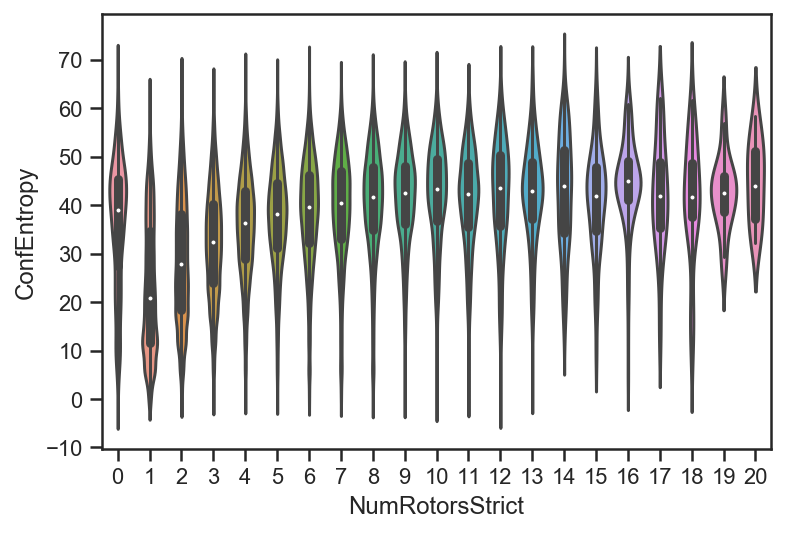

In [5]:
sns.violinplot(x="NumRotorsStrict", y="ConfEntropy", data=df)

Clearly entropy isn't very linear with the number of rotatable bonds - but perhaps we can get better error with a full linear model

In [6]:
lm1 = ols('ConfEntropy~NumRotorsStrict', data=df).fit()
print(lm1.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm1.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 1.820e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:23:46   Log-Likelihood:            -4.4828e+05
No. Observations:              115599   AIC:                         8.966e+05
Df Residuals:                  115597   BIC:                         8.966e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          26.6125      0.068    3

Nice, we've dropped the MAE from 16.0 J/mol•K to ~9 J/mol•K - although clearly this isn't a great model either

In [7]:
lm2 = ols('ConfEntropy~NumRotors', data=df).fit()
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm2.fittedvalues))

mean absolute error: 9.204663702523503


A bit better with the 'relaxed' rotor definition, but not much:

    - NumRotorsStrict = 9.4 J/mol•K
    - NumRotors = 9.2 J/mol•K

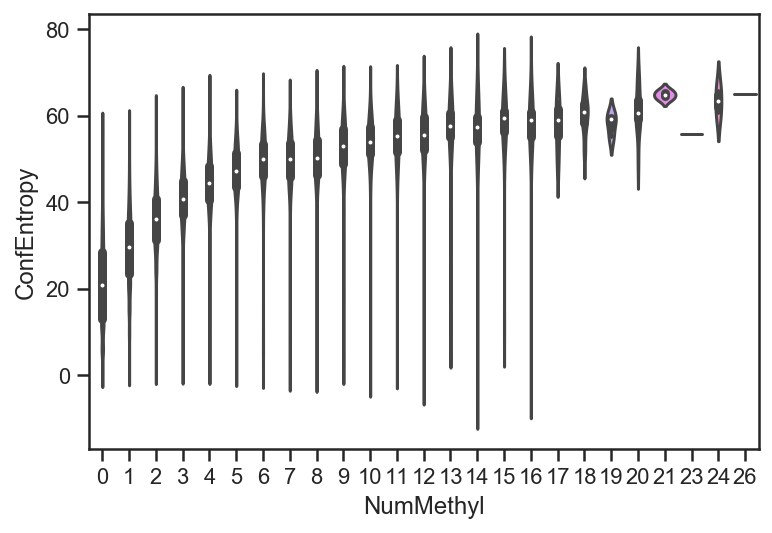

In [8]:
sns.violinplot(x="NumMethyl", y="ConfEntropy", data=df)

The # of methyl groups seems to have a much better prediction of conformational entropy

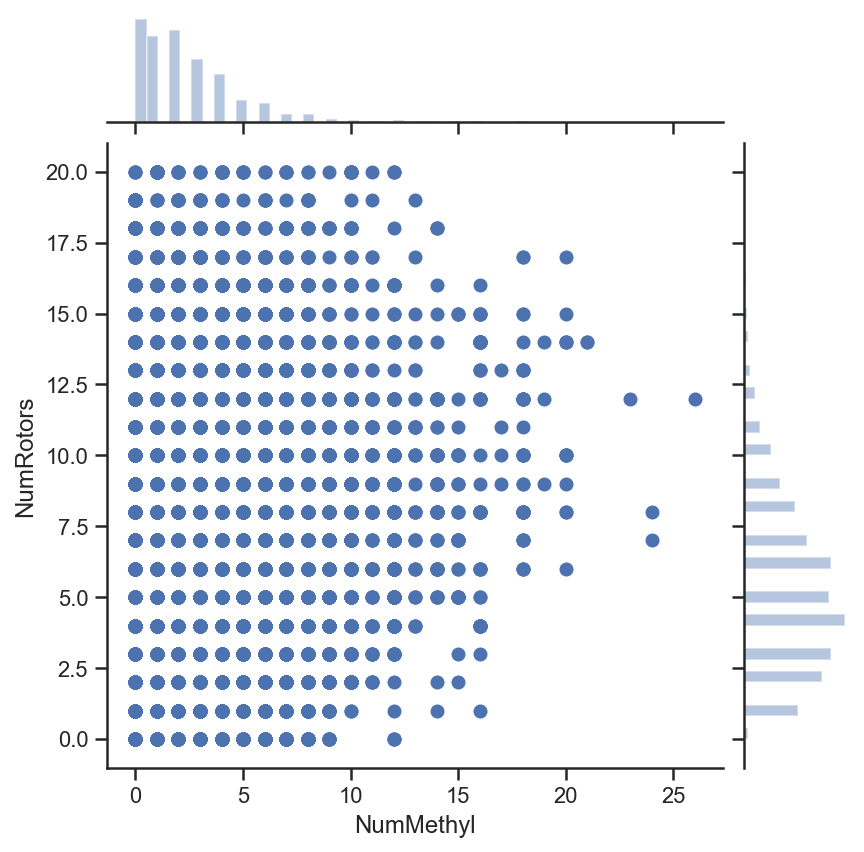

In [9]:
sns.jointplot(x="NumMethyl", y="NumRotors", data=df)

In [10]:
lm3 = ols('ConfEntropy~NumRotors+NumMethyl', df).fit()
print(lm3.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm3.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                 6.891e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:23:48   Log-Likelihood:            -4.1136e+05
No. Observations:              115599   AIC:                         8.227e+05
Df Residuals:                  115596   BIC:                         8.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.5121      0.053    389.512      0.0

In [11]:
lm4 = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)', df).fit()
print(lm4.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm4.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 9.722e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:23:48   Log-Likelihood:            -3.9970e+05
No. Observations:              115599   AIC:                         7.994e+05
Df Residuals:                  115596   BIC:                         7.994e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.64

Is the best constant? We can test this:

In [12]:
max_mae = 10.0
best_alpha = 0
for a in range(1,150):
    alpha = float(a)/100.0
    formula = 'ConfEntropy~np.log(NumRotors+{})+np.log(NumMethyl+{})'.format(alpha, alpha)
    lm = ols(formula, df).fit()
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = alpha
        max_mae = mae
        print('best so far', best_alpha, max_mae)

best so far 0.01 6.706011731069552
best so far 0.02 6.571880169240958
best so far 0.03 6.48501947644234
best so far 0.04 6.4193696907460005
best so far 0.05 6.366040619370766
best so far 0.06 6.321046055074343
best so far 0.07 6.282023838415413
best so far 0.08 6.247568241506269
best so far 0.09 6.216775823336675
best so far 0.1 6.189021132271438
best so far 0.11 6.163830377898594
best so far 0.12 6.140759984555193
best so far 0.13 6.119509455660531
best so far 0.14 6.099840344831142
best so far 0.15 6.081551390535535
best so far 0.16 6.064512049188624
best so far 0.17 6.048539773132788
best so far 0.18 6.033503699689713
best so far 0.19 6.019373217289966
best so far 0.2 6.006056525961546
best so far 0.21 5.99347186742961
best so far 0.22 5.981543864066238
best so far 0.23 5.970259897094125
best so far 0.24 5.959555645341025
best so far 0.25 5.94937062301818
best so far 0.26 5.939678718373377
best so far 0.27 5.930462525727501
best so far 0.28 5.921687778105688
best so far 0.29 5.91332

We might as well keep log(n+1) as our pick - there's not much difference if we let it go higher.

So the current model drops the MAE down to 5.7 J/mol•K which is almost a third of the initial model
What other factors are relevant? We have to tune the formula, because some columns (descriptors) cause errors in statsmodel - likely the values have errors - but none of these are expected to be important based on chemistry intutiton anyway. 

Once we have the (large) formula, we can use LASSO or similar regularization procedures to remove factors. We'll try a range of different penalities to find one with the lowest mean absolute error.

In [13]:
formula = 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumAtoms+NumBonds+ExactMolWt+Volume+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+NumBridgeheadAtoms+NumSpiroAtoms+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex'
print(formula)

ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumAtoms+NumBonds+ExactMolWt+Volume+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+NumBridgeheadAtoms+NumSpiroAtoms+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex


In [14]:
max_mae = 10.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

best so far 0.0 5.53212145552063
Intercept                28.015786
np.log(NumRotors + 1)     5.988674
np.log(NumMethyl + 1)    12.515551
NumAtoms                 -0.398859
NumBonds                 -0.007745
ExactMolWt               -0.003875
Volume                    0.001461
NumAmine                  1.357513
NumHydroxyl               1.308914
HDonors                  -1.593811
HAcceptors               -0.097544
RingCount                -0.390441
NumAromaticRings          0.606569
TPSA                     -0.001579
LabuteASA                 0.008600
MolMR                    -0.004145
MolLogP                   0.453627
HallKierAlpha            -1.099233
BertzCT                  -0.001379
BalabanJ                 -2.890645
Ipc                       0.000000
Kappa1                    0.237035
Kappa2                   -0.162049
Kappa3                    0.227077
FractionCSP3              4.561874
NumBridgeheadAtoms        0.164661
NumSpiroAtoms             0.902450
Asphericity           

Clearly many of these factors are removed by LASSO. We'll create a hand-tuned smaller subset of factors to compare with our initial model

In [15]:
lm5 = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP', df).fit()
print(mean_absolute_error(df['ConfEntropy'], lm5.fittedvalues))
print(lm5.summary())

5.530231562697118
                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 3.537e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:30:15   Log-Likelihood:            -3.9648e+05
No. Observations:              115599   AIC:                         7.930e+05
Df Residuals:                  115592   BIC:                         7.930e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept   

These new factors add some minor corrections, improving the mean absolute error from ~5.7 J/mol•K to ~5.5 J/mol•K. More importantly, the new model suggests that hydrogen-bonding groups change the entropy (not surprising, since intramolecular hydrogen bonds would decrease the flexibility), and a molecules with more rings tend to yield lower conformational entropy.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [17]:
# simple log(rotors+1) + log(methyls + 1) model
initial_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)'), df, df.ConfEntropy, cv=5)
print(initial_score.mean(), "+/-", initial_score.std())

0.5951999183162184 +/- 0.024108720857552886


In [18]:
# more complex model (with rings, hydrogen bonds, etc.)
new_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP'), df, df.ConfEntropy, cv=5)
print(new_score.mean(), "+/-", new_score.std())

0.6195731398599412 +/- 0.020751518091177912


We can see that the very simply log(rotors + 1) + log(methyl + 1) model is pretty good (RMSE 5.73 J/mol•K and cross-validated R^2 0.595) but the newer model improves both RMSE and cross-validated R^2.

In [19]:
# a set of cyclic peptides
df2 = pd.read_csv("data/peptides-entropy.csv")
# drop inf and nan
df2.replace([np.inf, -np.inf], np.nan)
df2.dropna(inplace=True)
print(len(df2.index))

5448


In [20]:
# The more complex model (with rings, hydrogen bonds, etc.)
peptide_predictions = lm5.predict(df2)
print(mean_absolute_error(df2['ConfEntropy'], peptide_predictions))

6.031481028370855


In [21]:
# the simple log(rotors + 1)+log(methy + 1) model
print(mean_absolute_error(df2['ConfEntropy'], lm4.predict(df2)))

4.8363903032205195


(Ironically, the simple model handles the cyclic peptides better)